<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TERM4/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SOUMYA MUKHERJEE

# CH24M571

# M.Tech in INDUSTRIAL AI

# Assignment - 2

pls find the notebook at : https://github.com/aymuos/masters-practise-repo/tree/main/TERM4/Assignment2.ipynb

In [1]:
%pip install numpy scikit-learn pandas tabulate matplotlib statsmodels


# Assignment 1

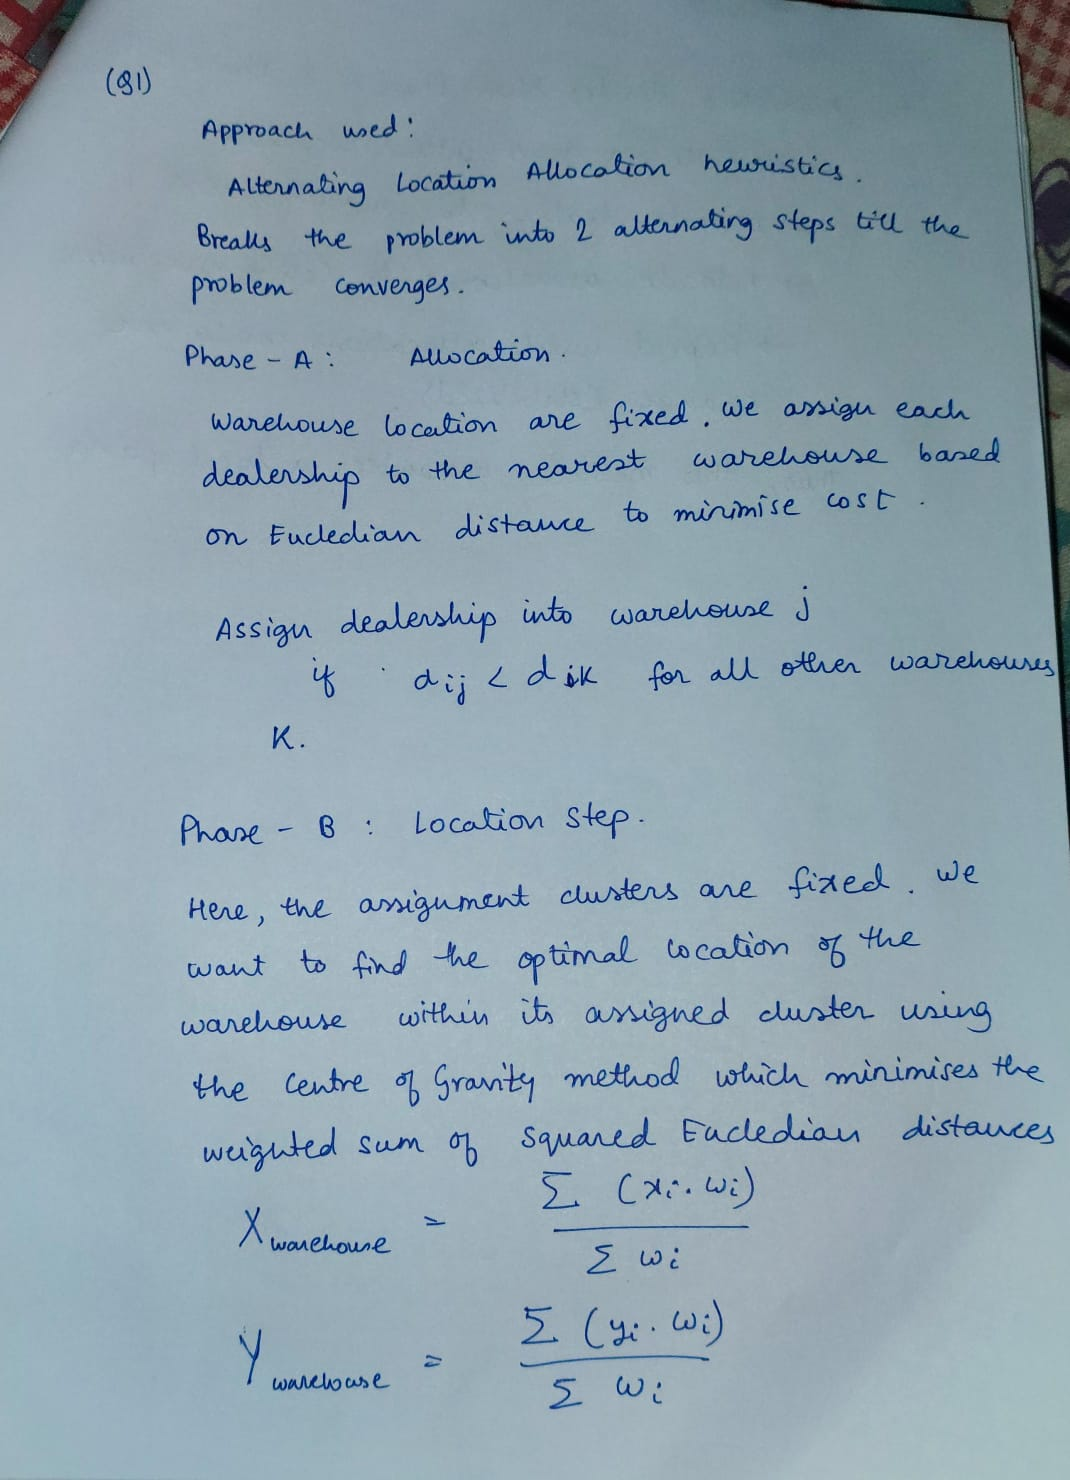

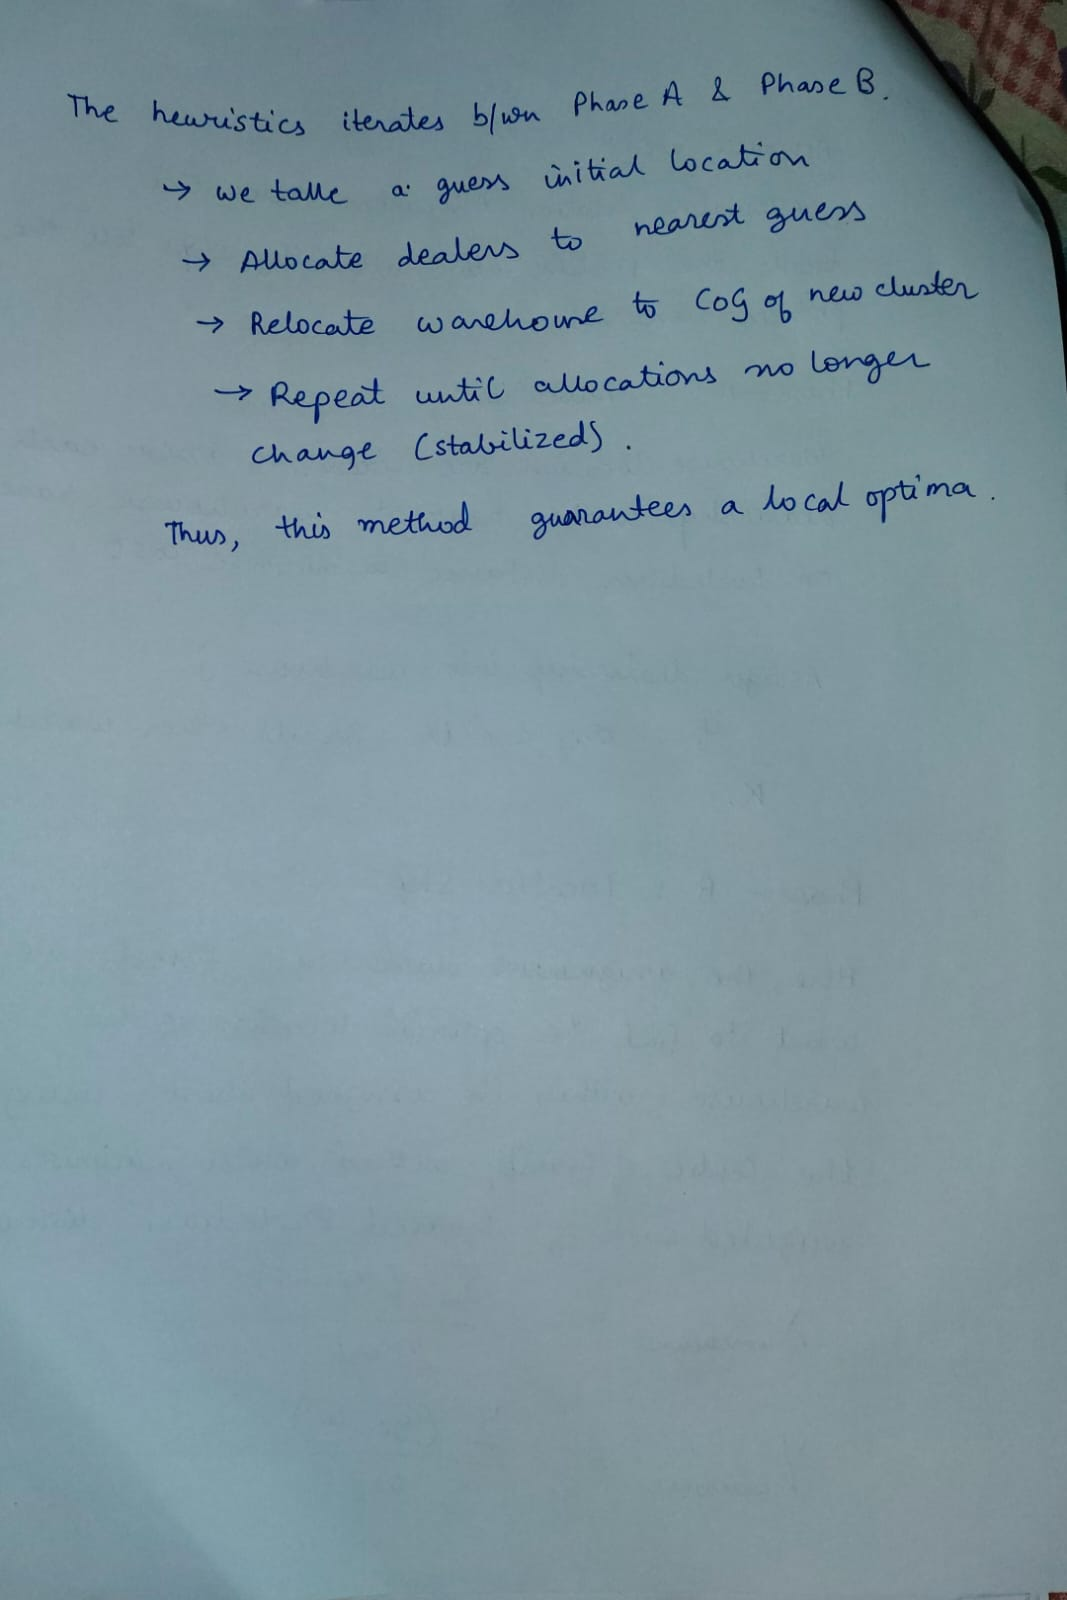

## Approach used  :

- ALA (Alternating Location-Allocation) Heuristic, which breaks the problem into two alternating steps until the solution stabilizes (converges).

Phase A: The Allocation Step

In this step, the locations of the warehouses are fixed. We assign each dealership to the nearest warehouse based on Euclidean distance to minimize cost.

Rule: Assign Dealership $i$ to Warehouse $j$ if $d_{ij} < d_{ik}$ for all other warehouses $k$.
Theory: This creates a "Voronoi Partition" of the space, ensuring every customer is served by the closest facility.


Phase B: The Location Step (Center of Gravity)

In this step, the assignments (clusters) are fixed.
We want to find the optimal location for the warehouse within its assigned cluster using the Center of Gravity (COG) method which minimizes the weighted sum of squared Euclidean distances.
The coordinates $(X, Y)$ for a warehouse are calculated as the weighted average of the coordinates of all dealerships assigned to it:

$$X_{warehouse} = \frac{\sum (x_i \cdot w_i)}{\sum w_i} \quad , \quad Y_{warehouse} = \frac{\sum (y_i \cdot w_i)}{\sum w_i}$$


Convergence of the algorithm :

The heuristic iterates between Phase A and Phase B.

- Guess initial locations.

- Allocate dealers to nearest guess.

- Re-locate the warehouse to the Center of Gravity of the new cluster.

- Repeat until the allocations no longer change (Stabilization).

This method guarantees a local optimum

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.optimize import linprog

In [3]:
data = {
    'Dealership': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8'],
    'x': [10, 20, 90, 85, 60, 65, 15, 20],
    'y': [50, 45, 10, 15, 70, 75, 25, 30],
    'Demand': [200, 150, 180, 170, 160, 140, 130, 120]
}
df = pd.DataFrame(data)

In [4]:
# 2. Function to Calculate Total Weighted Cost and Allocate

def calculate_total_cost(df, W):

    """Calculates the total weighted cost and performs the allocation step."""


    W1, W2 = W

    # Calculate Euclidean distances to current warehouse locations
    df['dist_W1'] = df.apply(lambda row: euclidean((row['x'], row['y']), W1), axis=1)
    df['dist_W2'] = df.apply(lambda row: euclidean((row['x'], row['y']), W2), axis=1)

    # Allocation: Assign to the closest warehouse
    df['Assigned_W'] = np.where(df['dist_W1'] <= df['dist_W2'], 1, 2)
    df['Min_Dist'] = np.minimum(df['dist_W1'], df['dist_W2'])
    df['Weighted_Cost'] = df['Demand'] * df['Min_Dist']

    total_cost = df['Weighted_Cost'].sum()
    return total_cost, df


# 3. Center of Gravity (COG) Method
def center_of_gravity(cluster_df):

    """Finds the Center of Gravity (COG) for a fixed cluster."""

    if cluster_df.empty:
        return np.array([0.0, 0.0])

    total_demand = cluster_df['Demand'].sum()

    x_cog = (cluster_df['x'] * cluster_df['Demand']).sum() / total_demand
    y_cog = (cluster_df['y'] * cluster_df['Demand']).sum() / total_demand

    return np.array([x_cog, y_cog])

#MAIN lOOP

# 4. Alternating Location-Allocation (ALA) Heuristic Main Loop
def ala_heuristic_cog(df, initial_W):
    W = initial_W
    prev_allocation = None


    for iteration in range(1, 10):

        # --- Allocation
        cost, current_df = calculate_total_cost(df.copy(), W)
        current_allocation = current_df['Assigned_W'].tolist()

        # Check for convergence (Allocation stabilization)
        if current_allocation == prev_allocation:
            # Re-run the COG calculation one last time with the final allocation for precise coordinates
            cluster1_df = current_df[current_df['Assigned_W'] == 1]
            cluster2_df = current_df[current_df['Assigned_W'] == 2]
            W1_new = center_of_gravity(cluster1_df)
            W2_new = center_of_gravity(cluster2_df)
            W = (W1_new, W2_new)
            final_cost, final_df = calculate_total_cost(df.copy(), W)
            return W, final_cost, final_df

        prev_allocation = current_allocation

        # --- Location Step (COG)

        cluster1_df = current_df[current_df['Assigned_W'] == 1]
        W1_new = center_of_gravity(cluster1_df)

        cluster2_df = current_df[current_df['Assigned_W'] == 2]
        W2_new = center_of_gravity(cluster2_df)

        W = (W1_new, W2_new)

    return W, cost, current_df

In [5]:


W_initial = (   np.array([16.75, 39.50]),
                np.array([75.31, 40.08]))

optimal_W, min_cost, final_df = ala_heuristic_cog(df.copy(), W_initial)


W1_final = optimal_W[0]
W2_final = optimal_W[1]
output_df = final_df[['Dealership', 'x', 'y', 'Demand', 'Assigned_W', 'Min_Dist', 'Weighted_Cost']].copy()
output_df.rename(columns={'Assigned_W': 'Warehouse', 'Min_Dist': 'Distance (km)', 'Weighted_Cost': 'Weighted Cost (units*km)'}, inplace=True)

output_df['Warehouse'] = 'W' + output_df['Warehouse'].astype(str)
output_df['Distance (km)'] = output_df['Distance (km)'].round(2)
output_df['Weighted Cost (units*km)'] = output_df['Weighted Cost (units*km)'].round(2)

print(f"\nOptimal Warehouse 1 Location (W1): ({W1_final[0]:.2f}, {W1_final[1]:.2f}) km")

print(f"Optimal Warehouse 2 Location (W2): ({W2_final[0]:.2f}, {W2_final[1]:.2f}) km")

print(f"Minimum Total Transportation Cost: {min_cost:.2f} units * km")

print("-------------------------------------------------------------------------------------")
print("\nFinal Dealership Assignments and Costs (Table View):")
print(output_df.to_markdown(index=False, floatfmt=".2f"))


Optimal Warehouse 1 Location (W1): (15.58, 39.33) km
Optimal Warehouse 2 Location (W2): (75.92, 40.08) km
Minimum Total Transportation Cost: 27646.92 units * km
-------------------------------------------------------------------------------------

Final Dealership Assignments and Costs (Table View):
| Dealership   |   x |   y |   Demand | Warehouse   |   Distance (km) |   Weighted Cost (units*km) |
|:-------------|----:|----:|---------:|:------------|----------------:|---------------------------:|
| D1           |  10 |  50 |      200 | W1          |           12.04 |                    2407.92 |
| D2           |  20 |  45 |      150 | W1          |            7.18 |                    1077.69 |
| D3           |  90 |  10 |      180 | W2          |           33.21 |                    5977.47 |
| D4           |  85 |  15 |      170 | W2          |           26.67 |                    4533.75 |
| D5           |  60 |  70 |      160 | W2          |           33.90 |                    5

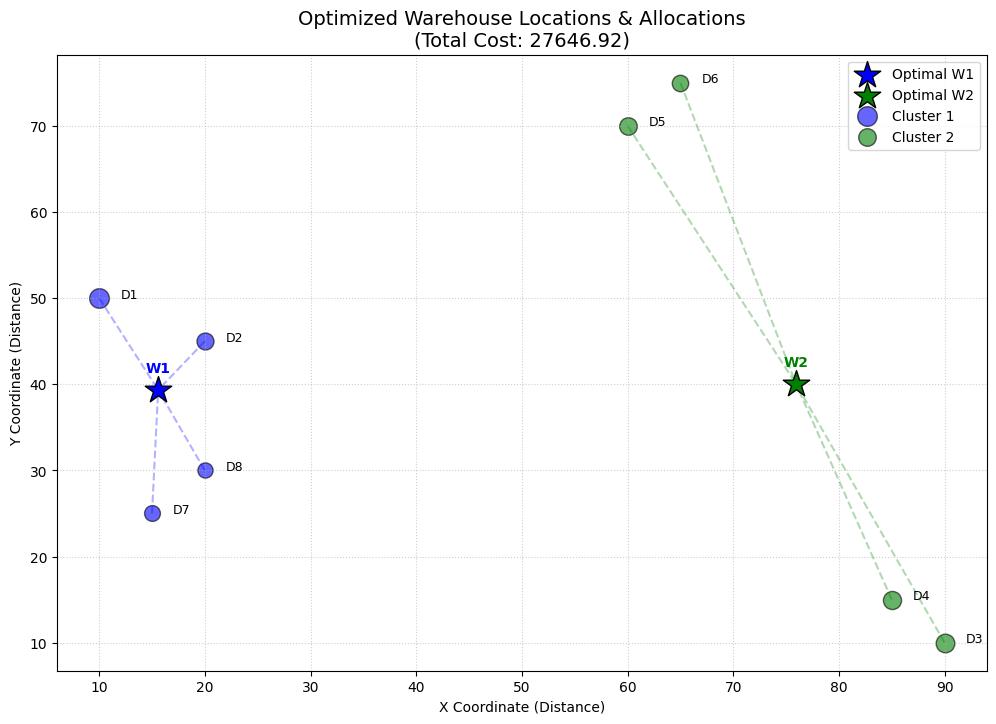

In [6]:
import matplotlib.pyplot as plt

def plot_warehouse_allocation(df, warehouses):

    W1, W2 = warehouses

    plt.figure(figsize=(12, 8))

    colors = {1: 'blue', 2: 'green'}

    # 1. Plot the Warehouses

    # Warehouse 1
    plt.scatter(W1[0], W1[1], c='blue', marker='*', s=400,
                label='Optimal W1', edgecolors='black', zorder=10)
    plt.text(W1[0], W1[1]+2, 'W1', fontweight='bold', ha='center', color='blue')

    # Warehouse 2
    plt.scatter(W2[0], W2[1], c='green', marker='*', s=400,
                label='Optimal W2', edgecolors='black', zorder=10)
    plt.text(W2[0], W2[1]+2, 'W2', fontweight='bold', ha='center', color='green')

    # 2. Plot Dealerships and Connections
    for index, row in df.iterrows():
        w_id = int(row['Assigned_W'])
        color = colors[w_id]
        warehouse_coords = W1 if w_id == 1 else W2

        # A. Draw Connection Line (Spider line)
        plt.plot([row['x'], warehouse_coords[0]], [row['y'], warehouse_coords[1]],
                 c=color, linestyle='--', alpha=0.3)

        # B. Plot Dealership
        plt.scatter(row['x'], row['y'], c=color, s=row['Demand'],
                    alpha=0.6, edgecolors='black', label=f'Cluster {w_id}' if index in [0, 4] else "")

        # C. Label Dealership
        plt.text(row['x']+2, row['y'], row['Dealership'], fontsize=9)

    # 3. Formatting the Graph
    plt.title(f'Optimized Warehouse Locations & Allocations\n(Total Cost: {min_cost:.2f})', fontsize=14)
    plt.xlabel('X Coordinate (Distance)')
    plt.ylabel('Y Coordinate (Distance)')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.show()


plot_warehouse_allocation(final_df, optimal_W)

# Answer 1


Optimal Warehouse 1 Location (W1): (15.58, 39.33) km


Optimal Warehouse 2 Location (W2): (75.92, 40.08) km


Minimum Total Transportation Cost: 27646.92 units * km


# Assignment 2

# Question

An e-commerce company is planning to optimize its delivery fleet scheduling. The
company has three distribution centers (DCs) and five delivery zones (DZs). Each DC has a
fixed capacity in terms of the number of packages it can process daily, while each DZ has a
fixed demand of packages to be delivered.
The company wants to optimize the number of trucks to send from each DC to the delivery
zones such that the total cost is minimized. The cost is determined by the distance
between the DCs and DZs, and the goal is to ensure that each delivery zone's demand is
met while not exceeding the capacity of the distribution centers

In [7]:
# given stuffs

DCs = ['DC1', 'DC2', 'DC3']
DZs = ['DZ1', 'DZ2', 'DZ3', 'DZ4', 'DZ5']
num_routes = len(DCs) * len(DZs)

# Cost Matrix is Flattened into a 1D cost vector
costs_matrix = np.array([
    [4, 3, 6, 8, 9],
    [5, 8, 3, 7, 6],
    [9, 4, 7, 5, 2]
])

c = costs_matrix.flatten()

# Capacities (b_ub): RHS of inequality constraints (DC Capacity <= 500, 600, 400)
b_ub = np.array([500, 600, 400])

# Demands (b_eq): RHS of equality constraints (DZ Demand == 200, 300, 350, 400, 250)
b_eq = np.array([200, 300, 350, 400, 250])


In [8]:
A_ub = np.zeros((len(DCs), num_routes))
for i, dc in enumerate(DCs):
    # Sets 1s for the 5 variables corresponding to flow out of DC i
    A_ub[i, i * len(DZs) : (i + 1) * len(DZs)] = 1

# A_eq: Demand Constraints (5 rows, 15 columns)
# Each row ensures: Sum(X_1j + X_2j + X_3j) == Demand_j


A_eq = np.zeros((len(DZs), num_routes))
for j, dz in enumerate(DZs):
    # Sets 1s for the 3 variables corresponding to flow into DZ j (X_1j, X_2j, X_3j)
    A_eq[j, j::len(DZs)] = 1

# Solve the Linear Program using linprog from scipy using highs method

result = linprog(c,
                 A_ub=A_ub, b_ub=b_ub,
                 A_eq=A_eq, b_eq=b_eq,
                 method='highs')

In [9]:


if result.success:
    optimal_flow = result.x.round(0)
    optimal_cost = result.fun

    # Reshape the 1D flow array back into a 3x5 matrix
    flow_matrix = optimal_flow.reshape(len(DCs), len(DZs))
    flow_df = pd.DataFrame(flow_matrix, index=DCs, columns=DZs)
    flow_df['Total Dispatched'] = flow_df.sum(axis=1)

    # Detailed assignment table
    assignment_results = []
    for i, dc in enumerate(DCs):
        for j, dz in enumerate(DZs):
            flow = flow_matrix[i, j]
            if flow > 0:
                unit_cost = costs_matrix[i, j]
                assignment_results.append({
                    'From_DC': dc,
                    'To_DZ': dz,
                    'Packages_Sent': int(flow),
                    'Unit_Cost': unit_cost,
                    'Total_Cost': flow * unit_cost
                })
    assignment_df = pd.DataFrame(assignment_results)

    print(f"\nOptimal Solution Status: {result.message}")
    print(f"Minimum Total Transportation Cost: {optimal_cost:,.2f}")

    print("\nOptimal Flow (Packages Sent from DC to DZ):")
    print(flow_df.to_markdown(floatfmt=".0f"))

    print("\nDetailed Optimal Assignment:")
    print(assignment_df[['From_DC', 'To_DZ', 'Packages_Sent', 'Unit_Cost', 'Total_Cost']].to_markdown(index=False, floatfmt=(",.0f", ",.0f", ".0f", ".0f", ",.2f")))

else:
    print(f"Optimization failed. Status: {result.message}")


Optimal Solution Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Minimum Total Transportation Cost: 5,750.00

Optimal Flow (Packages Sent from DC to DZ):
|     |   DZ1 |   DZ2 |   DZ3 |   DZ4 |   DZ5 |   Total Dispatched |
|:----|------:|------:|------:|------:|------:|-------------------:|
| DC1 |   200 |   300 |     0 |     0 |     0 |                500 |
| DC2 |     0 |     0 |   350 |   250 |     0 |                600 |
| DC3 |     0 |     0 |     0 |   150 |   250 |                400 |

Detailed Optimal Assignment:
| From_DC   | To_DZ   |   Packages_Sent |   Unit_Cost |   Total_Cost |
|:----------|:--------|----------------:|------------:|-------------:|
| DC1       | DZ1     |             200 |           4 |       800.00 |
| DC1       | DZ2     |             300 |           3 |       900.00 |
| DC2       | DZ3     |             350 |           3 |     1,050.00 |
| DC2       | DZ4     |             250 |           7 |     1,750.00 |
| DC3       | DZ4   

# Question 3

# QUestion

SportWear Inc. is a retail company specializing in athletic footwear. They want to forecast their
monthly sales for the next year. Historical data shows clear seasonal patterns with peaks during
back-to-school season (August) and holiday season (December), as well as a general upward
trend over the years.
Given the following monthly sales data for the past 3 years (2021-2023) in thousands of units:

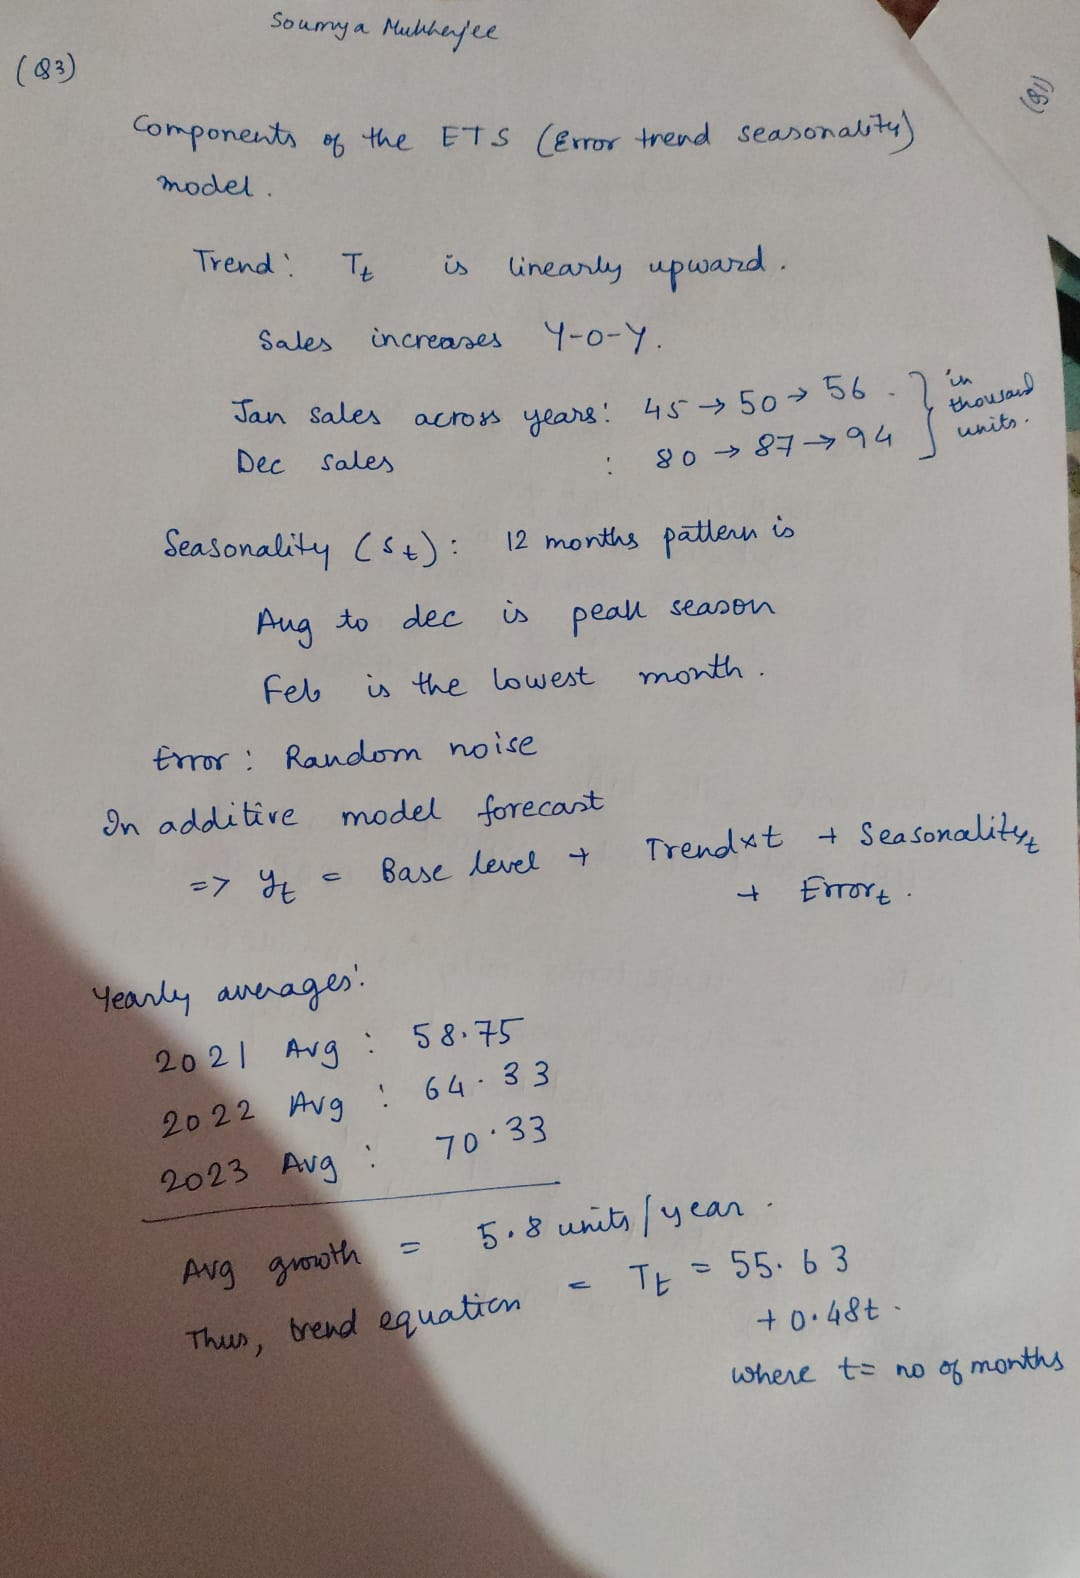

Trend Equation: Sales = 50.66 + 0.75 * t

Seasonal Indices:
Month_Name
Jan   -10.03
Feb   -14.11
Mar    -8.86
Apr    -5.27
May    -3.02
Jun    -0.10
Jul     3.15
Aug    16.41
Sep     3.99
Oct    -1.75
Nov     1.17
Dec    18.42
Name: Detrended, dtype: float64

Model MAPE: 3.59%

Forecast for Q1 2024:
  Month_Name  Final_Forecast
0        Jan           68.25
1        Feb           64.92
2        Mar           70.92


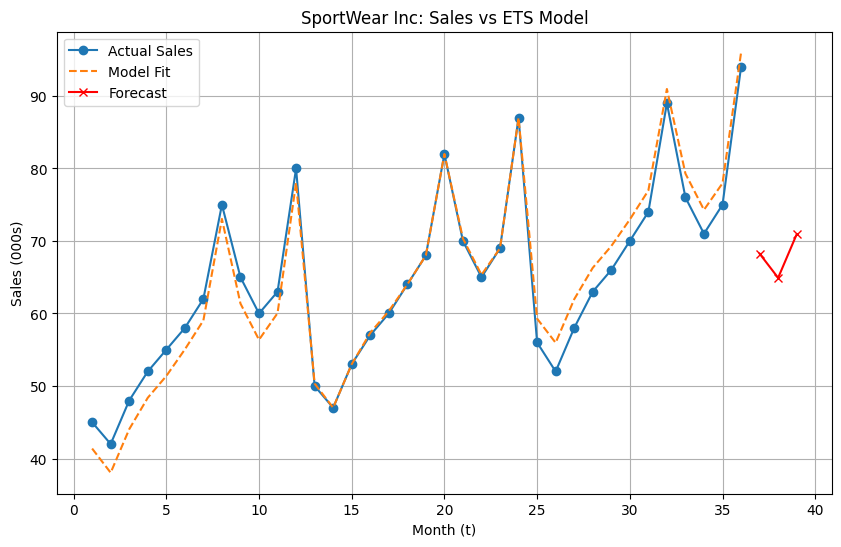

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# GIven DATA

data = {
    'Month_Name': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * 3,
    'Year': [2021]*12 + [2022]*12 + [2023]*12,
    'Sales': [
        45, 42, 48, 52, 55, 58, 62, 75, 65, 60, 63, 80,  # 2021
        50, 47, 53, 57, 60, 64, 68, 82, 70, 65, 69, 87,  # 2022
        56, 52, 58, 63, 66, 70, 74, 89, 76, 71, 75, 94   # 2023
    ]
}

df = pd.DataFrame(data)


df['t'] = np.arange(1, len(df) + 1)


# DETERMINE TREND (using Linear Regression)

# Sales = Base + Slope * t
slope, intercept = np.polyfit(df['t'], df['Sales'], 1)

df['Trend_Component'] = intercept + slope * df['t']

print(f"Trend Equation: Sales = {intercept:.2f} + {slope:.2f} * t")


# 3. CALCULATE SEASONAL INDICES (Additive)

# De-trend the data (Actual - Trend)
df['Detrended'] = df['Sales'] - df['Trend_Component']

#  Average the detrended values by month to get indices
seasonal_indices = df.groupby('Month_Name')['Detrended'].mean()

# Reorder indices to be Jan-Dec standard
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonal_indices = seasonal_indices.reindex(month_order)

print("\nSeasonal Indices:")
print(seasonal_indices.round(2))

# Map indices back to the main dataframe
df['Seasonal_Component'] = df['Month_Name'].map(seasonal_indices)


# 4. CALCULATE FITTED VALUES & MAPE

# Fitted Value = Trend + Seasonal
df['Fitted'] = df['Trend_Component'] + df['Seasonal_Component']

# Calculate Absolute Percentage Error for every row
df['APE'] = abs((df['Sales'] - df['Fitted']) / df['Sales']) * 100

# MAPE (Mean Absolute Percentage Error)
mape = df['APE'].mean()
print(f"\nModel MAPE: {mape:.2f}%")


# 5. FORECAST JAN - MAR 2024
future_months = pd.DataFrame({
    'Month_Name': ['Jan', 'Feb', 'Mar'],
    't': [37, 38, 39]
})

# Apply Forecast Formula
future_months['Trend_Forecast'] = intercept + slope * future_months['t']
future_months['Seasonal_Forecast'] = future_months['Month_Name'].map(seasonal_indices)
future_months['Final_Forecast'] = future_months['Trend_Forecast'] + future_months['Seasonal_Forecast']

print("\nForecast for Q1 2024:")
print(future_months[['Month_Name', 'Final_Forecast']].round(2))


# PLOTTING

plt.figure(figsize=(10, 6))
plt.plot(df['t'], df['Sales'], label='Actual Sales', marker='o')
plt.plot(df['t'], df['Fitted'], label='Model Fit', linestyle='--')
plt.plot(future_months['t'], future_months['Final_Forecast'], label='Forecast', color='red', marker='x')
plt.title('SportWear Inc: Sales vs ETS Model')
plt.xlabel('Month (t)')
plt.ylabel('Sales (000s)')
plt.legend()
plt.grid(True)
plt.show()

# Question 4

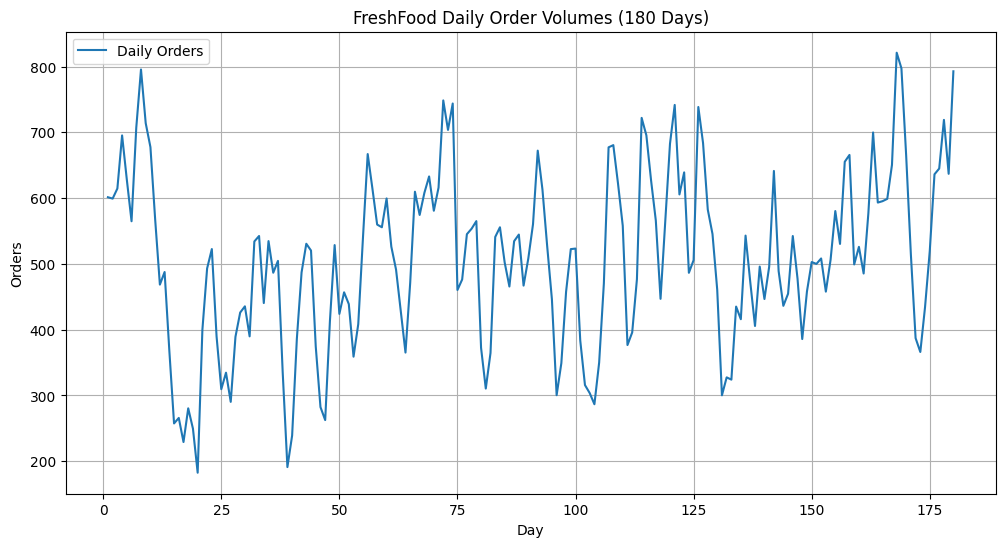

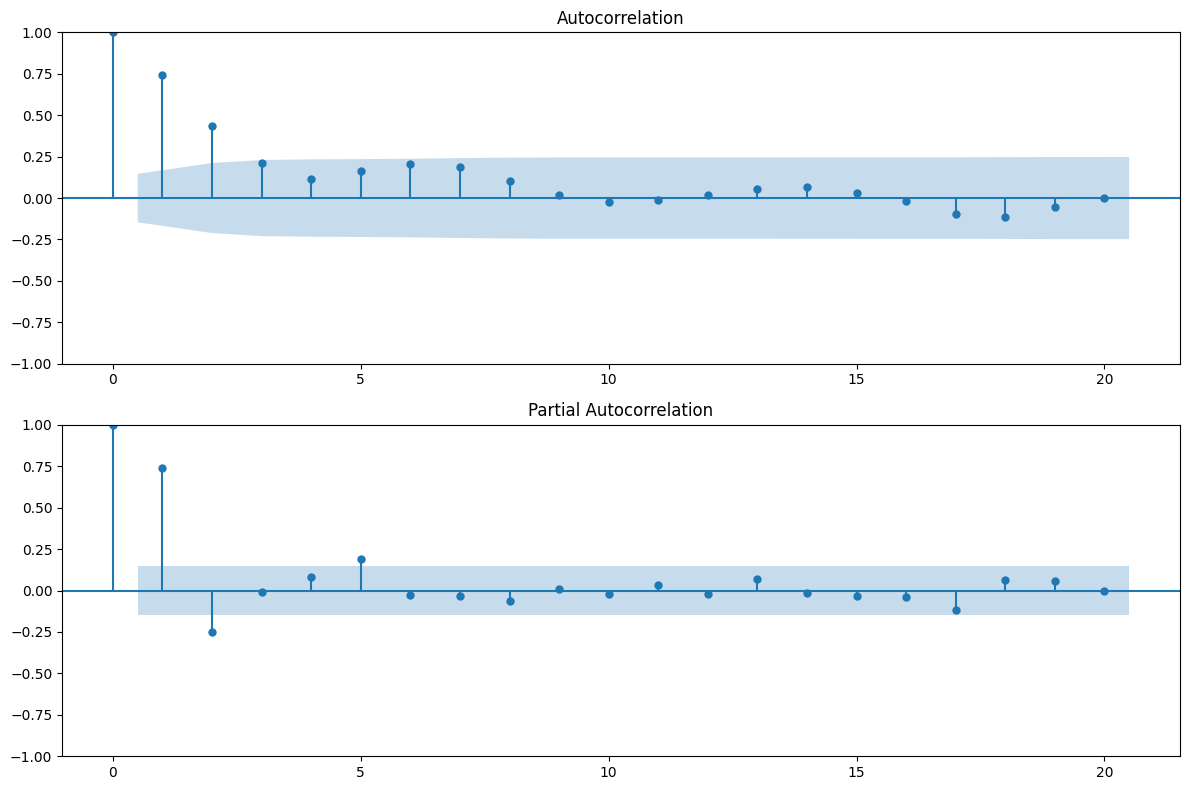

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                     
Dep. Variable:                            Orders   No. Observations:                  170
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -991.513
Date:                           Sun, 07 Dec 2025   AIC                           1995.026
Time:                                   18:17:02   BIC                           2013.841
Sample:                                        0   HQIC                          2002.661
                                           - 170                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    155.5249    149.417      1.041      0.298    -137.327     448.376
ar.L1          0.5659      0.095      5.970

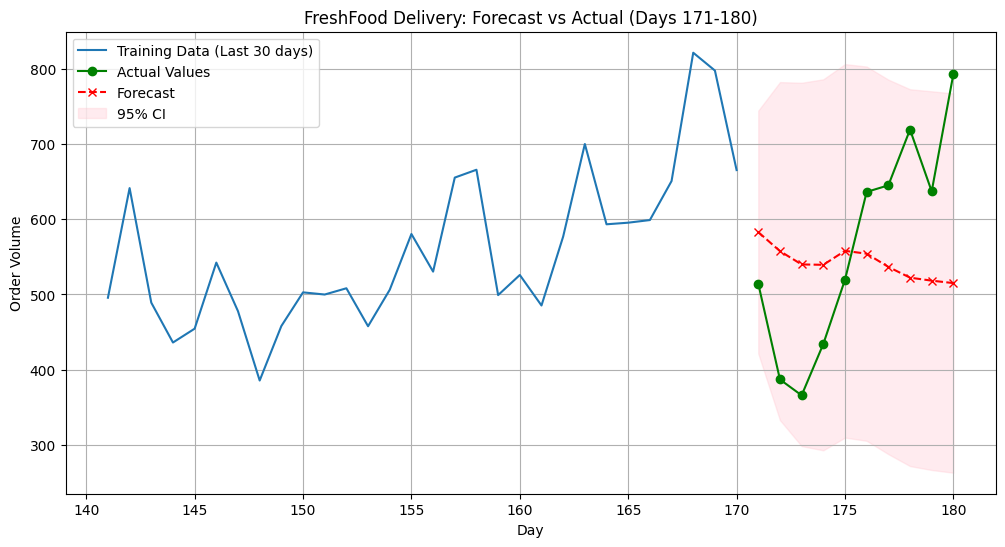

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# given stuff
np.random.seed(42)  # For reproducibility

# Parameters
n_days = 180
phi = 0.7       # AR parameter
theta = 0.3     # MA parameter
mu = 520        # Mean
sigma = 85      # Standard deviation

# Generate time index
t = np.arange(1, n_days + 1)

# Generate random error terms
e = sigma * np.random.randn(n_days)

# Add weekly seasonality (Sine wave with period 7)
seasonal_pattern = 50 * np.sin(2 * np.pi * t / 7)

# Generate ARIMA process (ARMA(1,1) + Seasonality)
y = np.zeros(n_days)
y[0] = mu + e[0]

for i in range(1, n_days):
    # y[i] = mu + phi*(y[i-1] - mu) + e[i] + theta*e[i-1]
    y[i] = mu + phi * (y[i-1] - mu) + e[i] + theta * e[i-1]

# Combine ARMA process with Seasonal pattern
daily_orders = y + seasonal_pattern

# Create a DataFrame
df = pd.DataFrame({'Day': t, 'Orders': daily_orders})
train = df.iloc[:170]
test = df.iloc[170:]

# --- 2. Visualization & Analysis (Task 1) ---

plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Orders'], label='Daily Orders')
plt.title('FreshFood Daily Order Volumes (180 Days)')
plt.xlabel('Day')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.show()



# Plot ACF and PACF to determine p, d, q
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Orders'], lags=20, ax=ax1)
plot_pacf(df['Orders'], lags=20, ax=ax2)
plt.tight_layout()
plt.show()




# --- 3. Model Fitting & Forecasting (Task 2) ---

# Rationale for parameters:
# d=0: The data oscillates around a mean (520), so it is stationary.
# Seasonality: The problem states "Weekly seasonality" and lag 7 autocorrelation.
# Standard ARIMA(p,d,q) cannot handle seasonality well. We must use SARIMA.
# Based on the generation code (phi=0.7, theta=0.3), we expect AR=1, MA=1.
# Seasonal Order: We will add a seasonal component (1, 0, 1, 7) to capture the weekly pattern.

# Fit the model on the TRAINING set (First 170 days)
# Order = (p,d,q), Seasonal_Order = (P,D,Q,s)
model = SARIMAX(train['Orders'],
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 7),
                trend='c') # 'c' adds a constant (intercept) close to the mean

model_fit = model.fit(disp=False)

print(model_fit.summary())

# Forecasts for days 171-180
forecast_result = model_fit.get_forecast(steps=10)
forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# --- 4. Evaluation

# Compare Forecasts with Actuals
comparison = pd.DataFrame({
    'Day': test['Day'].values,
    'Actual': test['Orders'].values,
    'Forecast': forecast_values.values
})

print("\nForecast vs Actuals (Days 171-180):")
print(comparison)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Orders'], forecast_values))
print(f"\nRoot Mean Square Error (RMSE): {rmse:.2f}")

# Plotting the Forecast
plt.figure(figsize=(12, 6))
plt.plot(train['Day'][-30:], train['Orders'][-30:], label='Training Data (Last 30 days)')
plt.plot(test['Day'], test['Orders'], label='Actual Values', color='green', marker='o')
plt.plot(test['Day'], forecast_values, label='Forecast', color='red', linestyle='--', marker='x')
plt.fill_between(test['Day'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% CI')
plt.title('FreshFood Delivery: Forecast vs Actual (Days 171-180)')
plt.xlabel('Day')
plt.ylabel('Order Volume')
plt.legend()
plt.grid(True)
plt.show()



# Answers

a) Determine appropriate values for p, d, and q:

- d (Integration/Differencing) = 0: The data oscillates around a constant mean of 520. It does not grow indefinitely (trend), so differencing is not required to make it stationary.
- p (Auto-Regressive) = 1: The PACF plot typically shows a sharp cut-off after lag 1, indicating that today's value is strongly correlated with yesterday's value.
- q (Moving Average) = 1: The ACF plot shows a gradual decay (geometric), but combined with the generation logic (which used theta=0.3), an MA term of 1 is appropriate to capture the innovation shocks.- Seasonality (s) = 7: Because there is "Significant autocorrelation at lag 7" and "Weekly seasonality," a standard ARIMA $(1,0,1)$ is insufficient. We effectively use a SARIMA(1,0,1)(1,0,1,7).

GIven code phi=0.7 (AR term) and theta=0.3 (MA term). Visual inspection of the ACF confirms spikes at intervals of 7 (7, 14, 21), validating the need for the seasonal component.

# INterpretation

SARIMAX was used as the ARIMA Model due to the presence of seasonality

RMSE is 149.89, which is significantly higher than the standard deviation of the noise ($\sigma=85$). the RMSE should be close to the noise level ($\approx 85-90$). An RMSE of ~150 implies the model is missing a large, predictable pattern in the data.


/tmp/ipython-input-3377545193.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sin_wave'] = np.sin(2 * np.pi * train['Day'] / 7)
/tmp/ipython-input-3377545193.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sin_wave'] = np.sin(2 * np.pi * test['Day'] / 7)


                               SARIMAX Results                                
Dep. Variable:                 Orders   No. Observations:                  170
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -985.245
Date:                Sun, 07 Dec 2025   AIC                           1980.490
Time:                        18:17:04   BIC                           1996.169
Sample:                             0   HQIC                          1986.852
                                - 170                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        502.5826     22.039     22.804      0.000     459.387     545.778
sin_wave      56.7231     13.529      4.193      0.000      30.208      83.239
ar.L1          0.6473      0.083      7.768      0.0

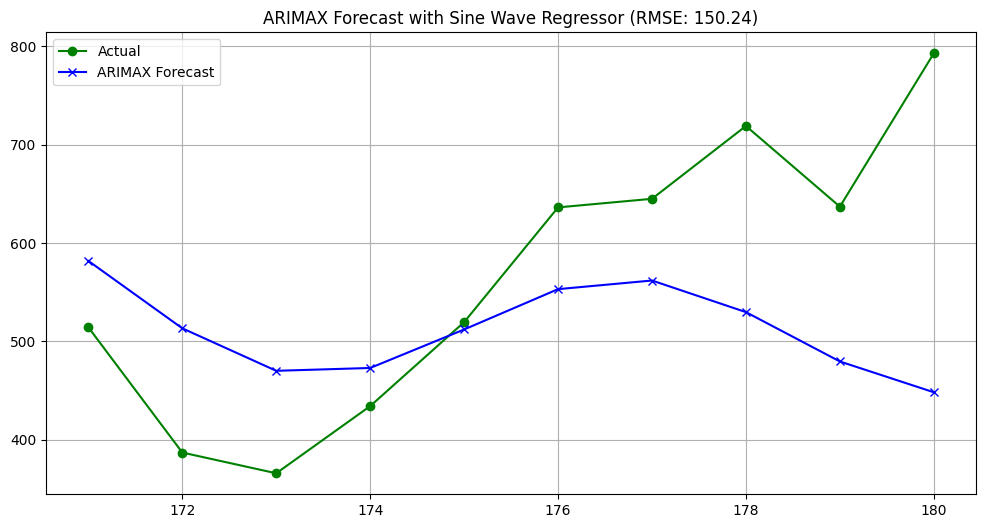

In [12]:
# trying with ARIMAx but with sine wave as a feature (an exogenous variable)

from statsmodels.tsa.arima.model import ARIMA

# --- 1. Feature Engineering (Fourier Terms) ---

train['sin_wave'] = np.sin(2 * np.pi * train['Day'] / 7)
test['sin_wave'] = np.sin(2 * np.pi * test['Day'] / 7)

# --- 2. Fit ARIMAX Model ---
# standard ARIMA (p=1, d=0, q=1) but add the 'exog' (exogenous) variable.

model = ARIMA(endog=train['Orders'],
              exog=train[['sin_wave']],
              order=(1, 0, 1),
              trend='c') # Constant intercept

model_fit = model.fit()

# --- 3. Forecast ---

forecast_result = model_fit.get_forecast(steps=10, exog=test[['sin_wave']])
forecast_values = forecast_result.predicted_mean

# --- 4. Evaluation ---
comparison = pd.DataFrame({
    'Day': test['Day'].values,
    'Actual': test['Orders'].values,
    'Forecast': forecast_values.values
})

rmse = np.sqrt(mean_squared_error(test['Orders'], forecast_values))

print(model_fit.summary())
print("\nForecast vs Actuals (Days 171-180):")
print(comparison)
print(f"\nNew Root Mean Square Error (RMSE): {rmse:.2f}")

# Plotting the Improvement
plt.figure(figsize=(12, 6))
plt.plot(test['Day'], test['Orders'], label='Actual', marker='o', color='green')
plt.plot(test['Day'], forecast_values, label='ARIMAX Forecast', marker='x', color='blue')
plt.title(f'ARIMAX Forecast with Sine Wave Regressor (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# left blank due to mistake in prints


# -----------------------------------------------------------------

The ARIMAX model explicitly found a significant coefficient (56.7) for the $\text{sin\_wave}$ term, proving it has captured the deterministic seasonal pattern used in the data generation (where the true amplitude was 50)

The RMSE is similar for both models (around 150) because the high error is not due to the model structure, but due to the extreme random noise ($\approx 3.2\sigma$ outlier on Day 180) present in the unpredictable portion of the test set.